In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

# Mute warnings
warnings.filterwarnings('ignore')

# set seed for reproducibility
np.random.seed(10)  # 10 for MESSI

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## Reading the dataset

In [29]:
# read the data
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

df_train.shape, df_test.shape


((42000, 785), (28000, 784))

In [30]:
# inspect the train dataset
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# split the features X and the target y
X = df_train.drop(columns='label')
y = df_train['label']

# inspect the shape of the features X & the target y
X.shape, y.shape

((42000, 784), (42000,))

In [32]:
# split the dataset 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# inpect the shapes
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((29400, 784), (12600, 784), (29400,), (12600,))

to plot the numbers we need to convert the first row in the dataframe to a numpy array, & then reshape it by (28,28) to look like an image.

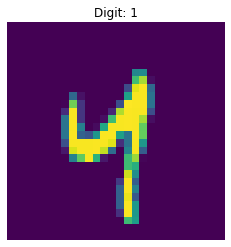

In [33]:
# view the first number
plt.imshow(X_train.to_numpy()[0].reshape(28, 28))  # (rows, columns)
# the label of the first number
plt.title(f"Digit: {y_train[0]}")
plt.axis("off")
plt.show() 

### View an Image in More Detail

(-0.5, 27.5, 27.5, -0.5)

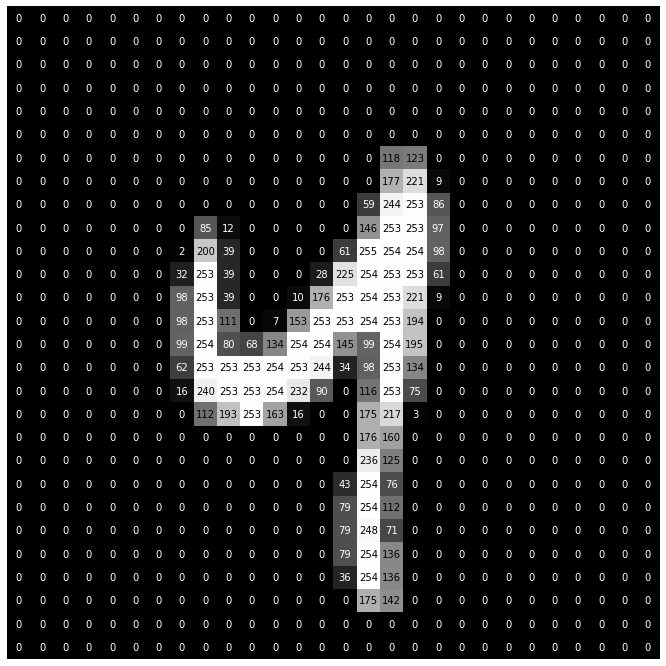

In [34]:
def visualize_input(img, ax):
    ax.imshow(img, cmap = 'gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy = (y,x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        color = 'white' if (img[x][y] < thresh) else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train.to_numpy()[0].reshape(28, 28), ax)  # pass image (28, 28)
plt.axis("off")

In [35]:
# convert the date frame to numpay array to feed it to the model
# convert the train dataset
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# convert the validation dataset
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

### Scale the pixel values

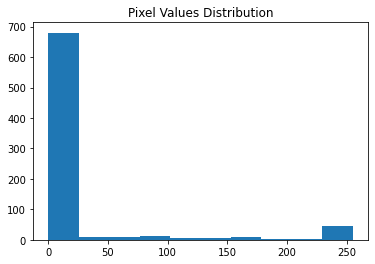

In [36]:
# plot the pixels distributions
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Values Distribution")
plt.show()

the pixel values range from 0 to 255: the background majority close to 0, and those close to 255 representing the digit.

Scaling the input data helps to speed up the training. Also, it reduces the chance of getting stuck in local optima, since we're using stochastic gradient descent to find the optimal weights for the network.

Neural network activations generally like their inputs to be Scaled. Scalling inputs to nodes in a network helps prevent the so-called vanishing (and exploding) gradients.

Let's reshape our inputs to a single vector vector and scale the pixel values to lie between 0 and 1.

In [37]:
# Scaling the features' pixels
X_train = X_train / 255 # over number of pixels
X_val = X_val / 255     # over number of pixels
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

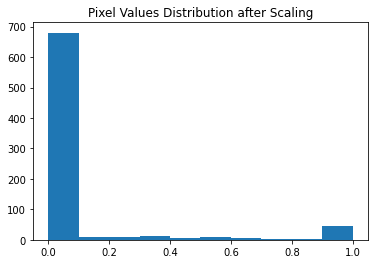

In [38]:
# plot the pixels distributions after Scaling
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Values Distribution after Scaling")
plt.show()

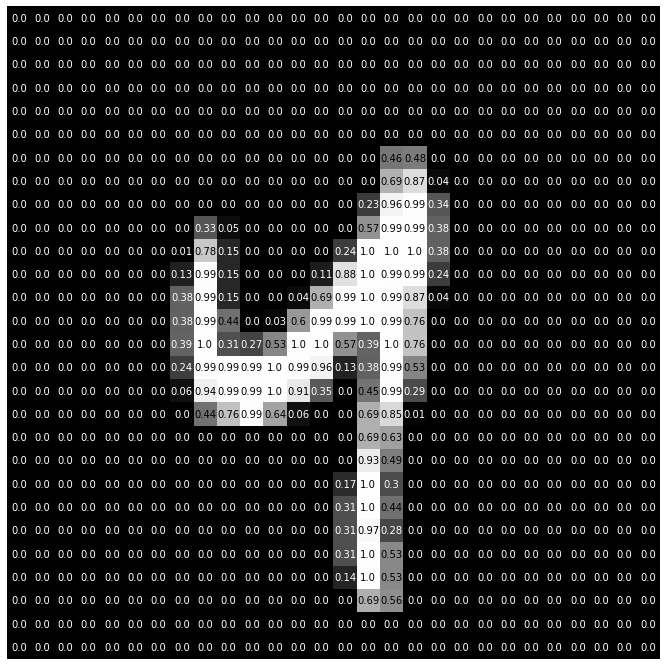

In [39]:
def visualize_input(img, ax):
    ax.imshow(img, cmap = 'gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy = (y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white' if (img[x][y] < thresh) else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
plt.axis("off")
visualize_input(X_train[0].reshape(28, 28), ax)  # pass image (28, 28)

### One-hot Encoding

In [40]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2932, 3295, 2883, 2996, 2850, 2710, 2881, 3042, 2854, 2957]))

Let's encode our categories - digits from 0 to 9 - using one-hot encoding. The result is a vector with a length equal to the number of categories. The vector is all zeroes except in the position for the respective category. Thus a `'5'` will be represented by `[0,0,0,0,1,0,0,0,0]`.

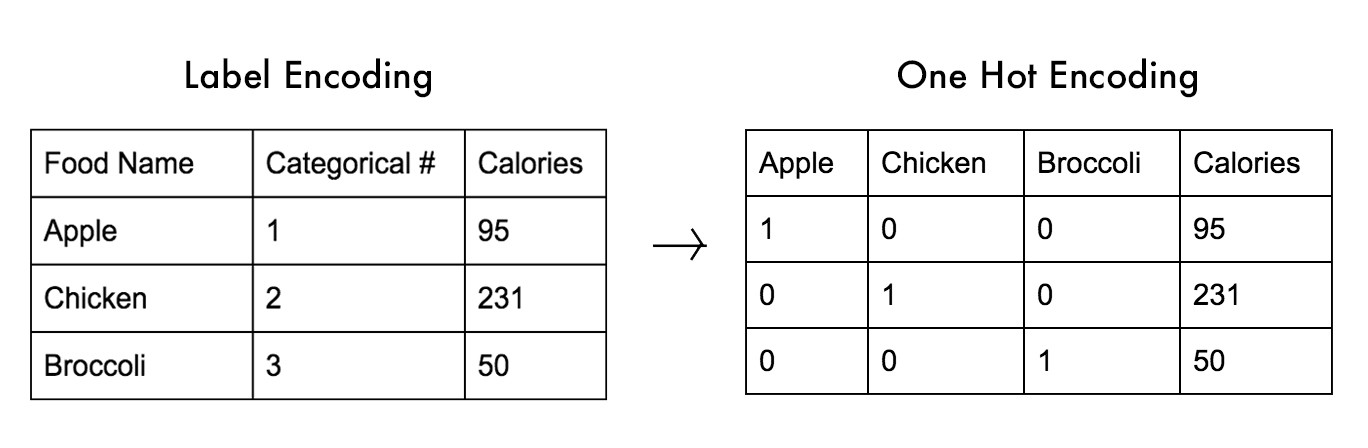

In [41]:
# Encoding the target
y_train = keras.utils.to_categorical(y_train, num_classes = 10)
y_val = keras.utils.to_categorical(y_val, num_classes = 10)

In [42]:
# inspect the input shape of the network to feed it to the model
[X_train.shape[1]]

[784]

## Modeling

In [43]:
# build the model
model = keras.Sequential([
    # The model
    layers.Dense(516, activation = 'relu'),
    layers.Dropout(0.7),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation = 'softmax')
])

Before training a model in `Keras`, we need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

In [44]:
# compiling the sequential model
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])

In [45]:
# initiate early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(patience = 4,
                                               min_delta = 0.001,
                                               restore_best_weights = True)

Generally the bigger the batch, the more stable our stochastic gradient descent updates will be. But beware of GPU memory limitations! We're going for a batch size of 128 and 25 epochs.

In [46]:
# train the model
training = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    batch_size = 128,
    epochs = 25,
    callbacks = [early_stopping],
    verbose = 0
)

In [47]:
# see the model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 516)               405060    
_________________________________________________________________
dropout_2 (Dropout)          (None, 516)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              529408    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10250     
Total params: 944,718
Trainable params: 944,718
Non-trainable params: 0
_________________________________________________________________


In [48]:
# evaluate the model
loss_and_metrics = model.evaluate(X_val, y_val, verbose=2)

print("Val Loss", loss_and_metrics[0])
print("Val Accuracy", loss_and_metrics[1])

394/394 - 1s - loss: 0.0752 - categorical_accuracy: 0.9777
Val Loss 0.07523734122514725
Val Accuracy 0.9776983857154846


To get a handle on our training progress we also graph the learning curve for our model looking at the loss and accuracy.

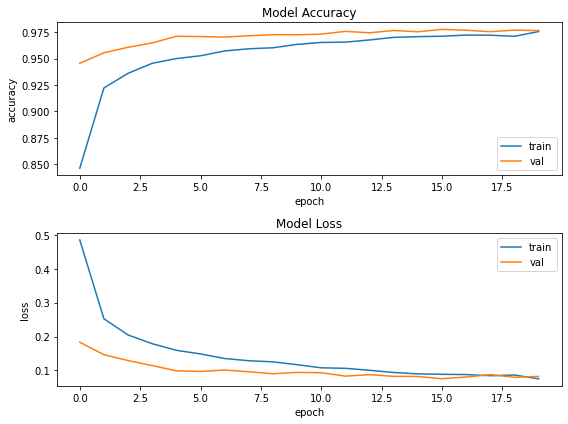

In [49]:
# plotting the metrics
fig = plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'lower right')

plt.subplot(2,1,2)
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')

plt.tight_layout()
plt.show()

## Predicting the target labels

In [50]:
# predect the labels of the test dataset, and return the exact number not an array (decode it)
y_pred = np.argmax(model.predict(df_test.to_numpy()), axis = -1)

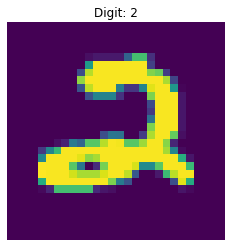

In [51]:
# inspect the first number in the test dataset predicted by the model
plt.imshow(df_test.to_numpy()[0].reshape(28, 28))
# the label of the first number
plt.title(f"Digit: {y_pred[0]}")
plt.axis("off")
plt.show()

## Submitting the predictions


In [52]:
# Generate a Submission File 
submission = pd.DataFrame({'ImageId':pd.Series(list(range(1, len(y_pred)+1))),
                           'Label':pd.Series(y_pred)})
# save the df
submission.to_csv("Submission.csv", index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


**For any suggestions, please let me know in the comments! Thanks.**